In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM echo_filtered
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo
0,67805,280987,182104,36,25443 days 10:29:14,M,NaN,NaN,NaN,WHITE,...,1885.0,1116.0,508.0,1201.0,-693.0,NaN,NaN,NaN,1,1
1,67118,216609,116009,62,25097 days 00:20:44,M,68.0,150.0,22.804931,PATIENT DECLINED TO ANSWER,...,698.0,2083.0,505.0,1525.0,-1020.0,335.5,730.0,-394.5,1,1
2,80320,281607,112086,75,28018 days 10:35:50,F,NaN,NaN,NaN,WHITE,...,1410.0,1630.0,12.0,1475.0,-1463.0,NaN,NaN,NaN,1,1
3,80083,206222,190243,86,16521 days 11:51:54,F,NaN,NaN,NaN,WHITE,...,1707.0,1813.0,1006.0,1430.0,-424.0,NaN,NaN,NaN,1,1
4,82745,232514,114585,115,27643 days 13:22:28,F,63.0,207.0,36.664399,WHITE,...,1229.0,2255.0,1105.5,1466.0,-360.5,NaN,NaN,NaN,1,1


In [6]:
len(ef)

2094

In [7]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [8]:
day30_mortality.value_counts()

False    1861
True      233
Name: ea_days_after_discharge_death, dtype: int64

In [9]:
ef['day30_mortality'] = day30_mortality

In [10]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [11]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    890
1    679
2    221
3    129
4    128
5     47
dtype: int64

In [146]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    1569
1     350
2     175
dtype: int64

In [171]:
model_data = ef[['ea_lv_systolic', 'ex_congestive_heart_failure'
                , 'mech_vent', 'mdrd', 'mdrd_discrete', 'mdrd_3', 'apsiii'
                , 'fl_day1_balance_ml', 'day30_mortality']].copy()
age = ef.age_at_intime/np.timedelta64('1', 'Y')
age.loc[age<0] = age.max()
model_data['age'] = age
model_data.loc[model_data.ea_lv_systolic == -50] = np.nan
model_data = model_data.dropna()
## normalize the continuous variables
for var in ['apsiii', 'age', 'fl_day1_balance_ml', 'mdrd']:
    mu = model_data[var].mean()
    std = model_data[var].std()
    model_data[var] = (model_data[var]-mu)/std
model_data['ea_lv_systolic'] = model_data.ea_lv_systolic.astype(int) + 2
model_data['ex_congestive_heart_failure'] = model_data.ex_congestive_heart_failure.astype(int)
model_data['mech_vent'] = model_data.mech_vent.astype(int)
model_data['day30_mortality'] = model_data.day30_mortality.astype(int)
model_data['mdrd_discrete'] = model_data.mdrd_discrete.astype(int) + 1
model_data['mdrd_3'] = model_data.mdrd_3.astype(int) + 1
print(len(model_data))
model_data.head()

1716


,ea_lv_systolic,ex_congestive_heart_failure,mech_vent,mdrd,mdrd_discrete,mdrd_3,apsiii,fl_day1_balance_ml,day30_mortality,age
0,3,0,0,0.611369,1,1,-1.139052,-0.213759,0,0.405750
1,2,0,0,0.618537,1,1,0.000812,0.171099,0,0.336295
2,2,0,1,0.798723,1,1,-0.759098,-0.009192,0,0.922015
3,2,0,0,0.528223,1,1,-0.801315,0.063641,0,-1.383021
4,1,1,1,-1.286615,5,3,0.802939,0.239553,0,0.846854


### Model using full 6 class MDRD

In [14]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       , 'mech_vent': model_data.mech_vent
       , 'mdrd_discrete': model_data.mdrd_discrete
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fl_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [18]:
model_code = """

data{
    int<lower=0> N;
    
    int<lower=1, upper=5> ea_lv_systolic[N];
    int<lower=0, upper=1> ex_congestive_heart_failure[N];
    int<lower=0, upper=1> mech_vent[N];
    int<lower=1, upper=6> mdrd_discrete[N];
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[5] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    real beta_mech_vent;
    vector[6] beta_mdrd_discrete;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[5] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    real gamma_mech_vent;
    vector[6] gamma_mdrd_discrete;
    
    vector[5] gamma_lv_sys_by_chf;
    matrix[5,6] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    for (i in 1:N)
        y_hat[i] <- bias
           + beta_ea_lv_systolic[ea_lv_systolic[i]]
           + beta_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
           + beta_mech_vent*mech_vent[i]
           + beta_mdrd_discrete[mdrd_discrete[i]]
           + beta_apsiii*apsiii[i]
           + beta_age*age[i]
           + fluid_day1_balance[i]*(beta_fluid
              + gamma_ea_lv_systolic[ea_lv_systolic[i]]
              + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
              + gamma_mech_vent*mech_vent[i]
              + gamma_mdrd_discrete[mdrd_discrete[i]]
              + gamma_lv_sys_by_chf[ea_lv_systolic[i]]*ex_congestive_heart_failure[i]
              + gamma_lv_sys_by_mdrd[ea_lv_systolic[i], mdrd_discrete[i]]
              );
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    beta_mech_vent ~ normal(0,1);
    beta_mdrd_discrete ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    gamma_mech_vent ~ normal(0,1);
    gamma_mdrd_discrete ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    for (i in 1:5)
        gamma_lv_sys_by_mdrd[i] ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}

generated quantities{
    

}

"""

In [137]:
model_fit = pystan.stan(model_code=model_code, data=data
                       , iter=2000, chains=1, n_jobs=1, algorithm='NUTS')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ca43b65cb7fd844fd12e3cce125cb00 NOW.


In [138]:
model_fit

Inference for Stan model: anon_model_8ca43b65cb7fd844fd12e3cce125cb00.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bias                               -2.88    0.02   0.63  -4.16  -3.25  -2.87  -2.48  -1.66 1000.0    1.0
beta_ea_lv_systolic[0]              0.53    0.02   0.51  -0.42   0.19    0.5   0.86   1.51 1000.0    1.0
beta_ea_lv_systolic[1]              0.08    0.01   0.47  -0.85  -0.23   0.08   0.38   1.01 1000.0    1.0
beta_ea_lv_systolic[2]             -0.49    0.02   0.52  -1.53  -0.83  -0.47  -0.13   0.53 1000.0    1.0
beta_ea_lv_systolic[3]             -0.04    0.02   0.61  -1.15  -0.47  -0.05   0.38   1.13 1000.0    1.0
beta_ea_lv_systolic[4]              0.09    0.02   0.63  -1.15  -0.33    0.1   0.49   1.35 1000.0    1.0
beta_ex_congestive_heart_failure     1.3  9.5e-3    0.3   0.73   1.09    1.3

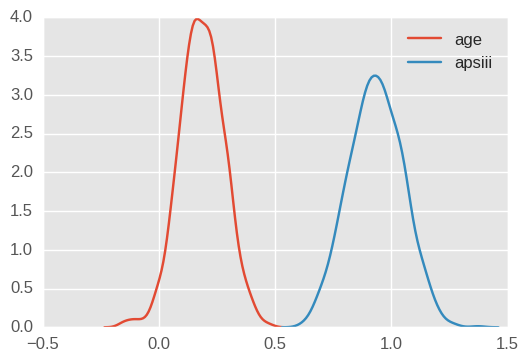

In [144]:
age_apsiii = model_fit.extract(['beta_age', 'beta_apsiii'])
for key in ['age', 'apsiii']:
    sns.kdeplot(age_apsiii['beta_'+key], label=key)
plt.legend(loc='best')

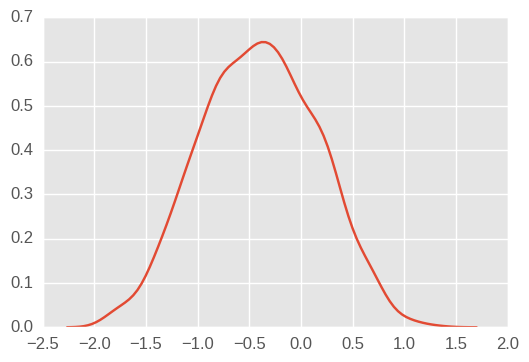

In [139]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

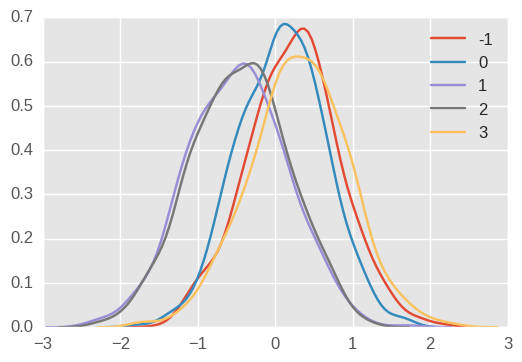

In [140]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

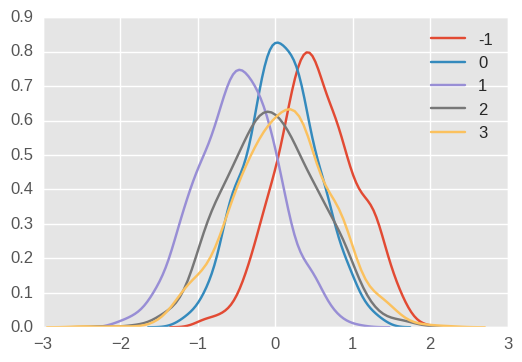

In [141]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

In [28]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715
0,-4.463604,-3.578601,-3.309332,-4.507319,1.820884,-2.271463,-4.260280,-2.855803,-3.531037,1.212933,...,-4.332082,-4.202372,-1.516786,0.075741,-2.489982,-1.941364,-4.816163,-2.957609,-3.034898,-4.279013
1,-4.745060,-3.446198,-3.103354,-4.181879,2.347743,-2.667536,-3.869935,-2.939413,-3.834504,0.169694,...,-4.851360,-4.403061,-1.279315,0.480048,-2.684148,-2.245250,-4.670448,-3.740258,-3.179075,-4.049473
2,-4.676466,-3.182539,-2.556159,-4.379840,1.261823,-1.634069,-3.935207,-2.285209,-3.468466,0.716852,...,-4.150956,-3.854983,0.599250,0.096118,-2.130545,-3.039768,-4.768182,-4.080970,-2.227929,-3.775333
3,-4.889111,-3.008015,-2.475768,-4.279130,0.712031,-1.689001,-3.738304,-2.874432,-3.548180,1.178105,...,-4.396326,-3.910684,-0.560530,-0.049542,-1.888736,-3.334884,-4.798912,-4.779639,-3.641375,-3.617366
4,-5.559339,-3.542022,-3.465436,-4.627523,1.107469,-2.242780,-4.236959,-3.344174,-3.849297,-0.130432,...,-5.052337,-4.619988,-1.124321,0.480094,-2.612191,-2.632249,-5.177716,-4.478480,-3.549250,-4.370826


In [30]:
y_hat_mu = y_hats.mean()

In [32]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [33]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.91025641025641024

In [40]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

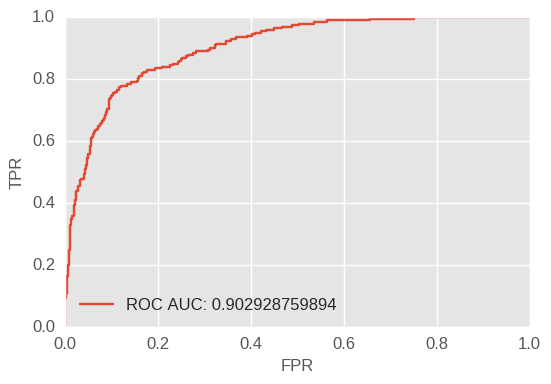

In [46]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

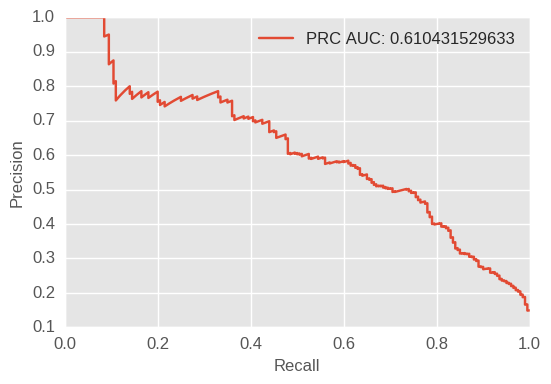

In [47]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [118]:
## plot threshold vs accuracy
def threshold_accuracy(y_true, y_pred):
    I = y_pred.argsort()
    y_true = y_true[I]
    y_pred = y_pred[I]
    tru = np.cumsum(y_true[::-1])[::-1]
    fls = np.cumsum(1-y_true) - 1
    cor = tru+fls
    acc = cor / float(len(y_pred))
    return acc, y_pred, y_true

0.912004662005 -0.174481151172


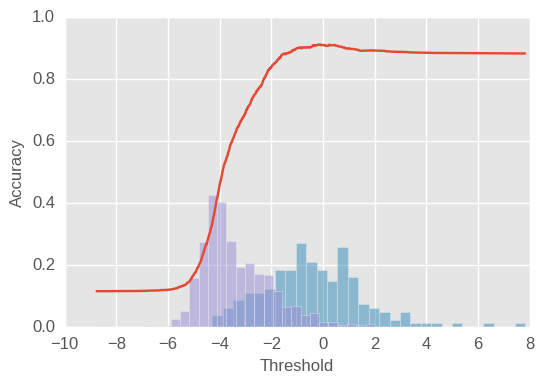

In [120]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [76]:
((y_hat_mu >= -0.872668315622) == model_data.day30_mortality).mean()

0.90268065268065267

In [34]:
model_data.day30_mortality.mean()

0.11655011655011654

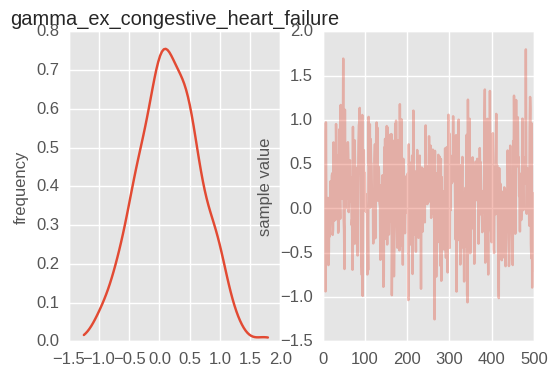

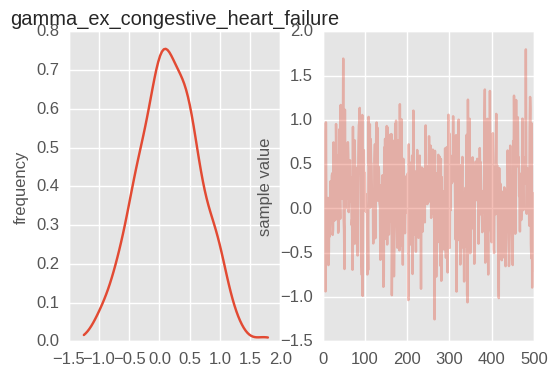

In [21]:
model_fit.plot(['gamma_ex_congestive_heart_failure'])

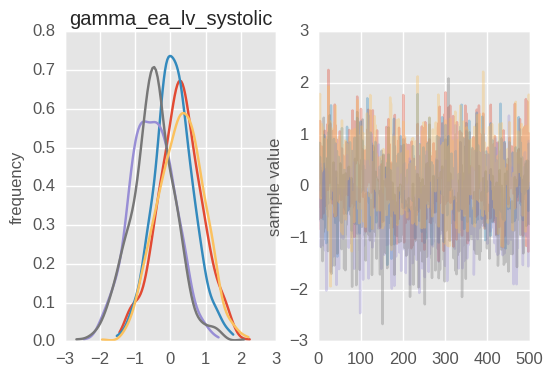

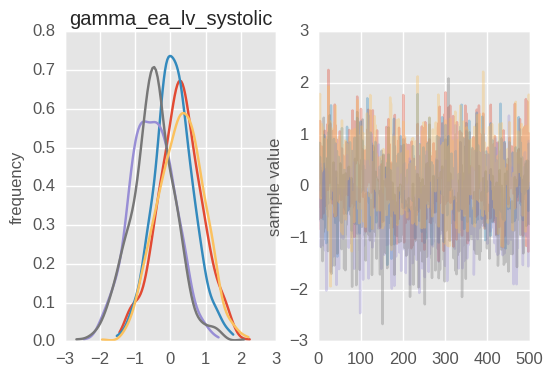

In [22]:
model_fit.plot(['gamma_ea_lv_systolic'])

### Model using 3 class MDRD

In [150]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       , 'mech_vent': model_data.mech_vent
       , 'mdrd': model_data.mdrd_3
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fl_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [151]:
model_code = """

data{
    int<lower=0> N;
    
    int<lower=1, upper=5> ea_lv_systolic[N];
    int<lower=0, upper=1> ex_congestive_heart_failure[N];
    int<lower=0, upper=1> mech_vent[N];
    int<lower=1, upper=3> mdrd[N];
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[5] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    real beta_mech_vent;
    vector[3] beta_mdrd;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[5] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    real gamma_mech_vent;
    vector[3] gamma_mdrd;
    
    vector[5] gamma_lv_sys_by_chf;
    matrix[5,3] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    for (i in 1:N)
        y_hat[i] <- bias
           + beta_ea_lv_systolic[ea_lv_systolic[i]]
           + beta_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
           + beta_mech_vent*mech_vent[i]
           + beta_mdrd[mdrd[i]]
           + beta_apsiii*apsiii[i]
           + beta_age*age[i]
           + fluid_day1_balance[i]*(beta_fluid
              + gamma_ea_lv_systolic[ea_lv_systolic[i]]
              + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
              + gamma_mech_vent*mech_vent[i]
              + gamma_mdrd[mdrd[i]]
              + gamma_lv_sys_by_chf[ea_lv_systolic[i]]*ex_congestive_heart_failure[i]
              + gamma_lv_sys_by_mdrd[ea_lv_systolic[i], mdrd[i]]
              );
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    beta_mech_vent ~ normal(0,1);
    beta_mdrd ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    gamma_mech_vent ~ normal(0,1);
    gamma_mdrd ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    for (i in 1:5)
        gamma_lv_sys_by_mdrd[i] ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}

generated quantities{
    

}

"""

In [152]:
model_fit = pystan.stan(model_code=model_code, data=data
                       , iter=2000, chains=1, n_jobs=1, algorithm='NUTS')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41ad18c02fa8f41aac928db5c33d4650 NOW.


In [153]:
model_fit

Inference for Stan model: anon_model_41ad18c02fa8f41aac928db5c33d4650.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bias                                -2.7    0.02   0.76  -4.21  -3.19  -2.69  -2.21  -1.25 1000.0    1.0
beta_ea_lv_systolic[0]              0.51    0.02   0.52  -0.51   0.17    0.5   0.84   1.53 1000.0    1.0
beta_ea_lv_systolic[1]              0.04    0.02   0.49  -0.86  -0.25   0.05   0.35   0.98 1000.0    1.0
beta_ea_lv_systolic[2]             -0.56    0.02   0.54  -1.64   -0.9  -0.56   -0.2   0.47 1000.0    1.0
beta_ea_lv_systolic[3]             -0.03    0.02    0.6  -1.31   -0.4  -0.03   0.35   1.11 1000.0    1.0
beta_ea_lv_systolic[4]              0.02    0.02   0.62  -1.18  -0.39   0.03   0.42   1.24 1000.0    1.0
beta_ex_congestive_heart_failure    1.21    0.01   0.33   0.57   0.98   1.23

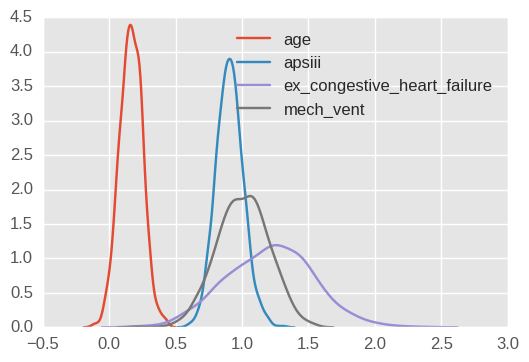

In [155]:
factors = model_fit.extract(['beta_age', 'beta_apsiii', 'beta_ex_congestive_heart_failure', 'beta_mech_vent'])
for key in ['age', 'apsiii', 'ex_congestive_heart_failure', 'mech_vent']:
    sns.kdeplot(factors['beta_'+key], label=key)
plt.legend(loc='best')

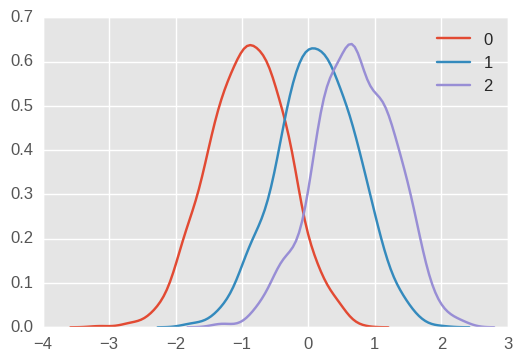

In [157]:
factors = model_fit.extract('beta_mdrd')['beta_mdrd']
for i in range(3):
    sns.kdeplot(factors[:,i], label=str(i))
plt.legend(loc='best')

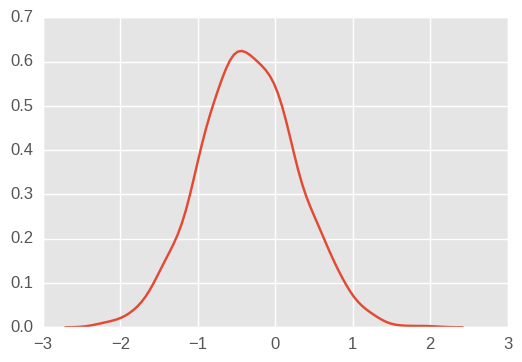

In [158]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

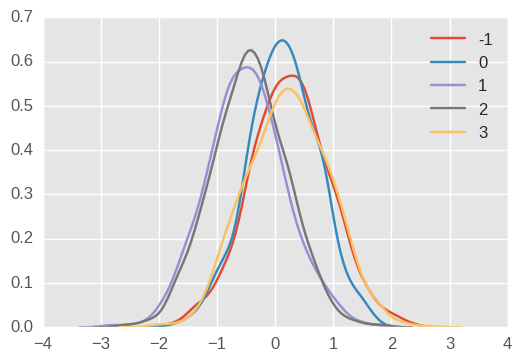

In [159]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

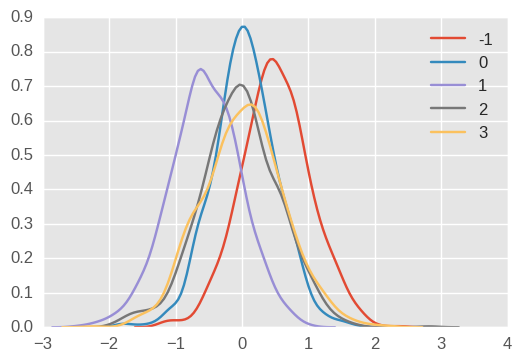

In [160]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

In [161]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715
0,-5.037615,-3.352750,-3.194830,-4.382990,1.416147,-2.055765,-4.053806,-3.012662,-3.460050,-0.132244,...,-4.250686,-4.032787,0.173011,-0.006479,-2.360406,-1.579212,-4.741074,-3.077444,-2.035176,-4.020277
1,-4.922401,-3.434888,-2.900399,-4.377662,1.908523,-2.250925,-4.100560,-2.540593,-3.459136,-0.805753,...,-4.199711,-4.041016,-1.321351,2.623792,-2.396532,-2.505783,-4.689306,-3.627932,-2.247359,-4.081407
2,-5.618998,-3.760549,-3.133816,-5.094774,1.921193,-2.305312,-4.768623,-2.808156,-3.528478,0.444545,...,-4.196345,-4.220455,-0.241877,-0.357537,-2.861059,-1.861247,-5.338790,-3.703914,-2.401115,-4.570657
3,-5.456275,-3.839687,-3.273671,-4.914716,2.228728,-1.928697,-4.726336,-2.876920,-3.407781,0.124224,...,-3.885770,-4.066975,-1.080983,0.366841,-2.334942,-2.981495,-5.021425,-4.577233,-2.872102,-4.548921
4,-4.030311,-3.450285,-2.986056,-4.353307,1.382476,-2.291353,-4.158168,-2.714467,-3.237487,-0.847521,...,-3.858730,-3.869597,-0.850741,2.153005,-2.524230,-2.075029,-4.555665,-3.521263,-2.453400,-4.108064


In [162]:
y_hat_mu = y_hats.mean()

In [163]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [164]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.90734265734265729

In [165]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

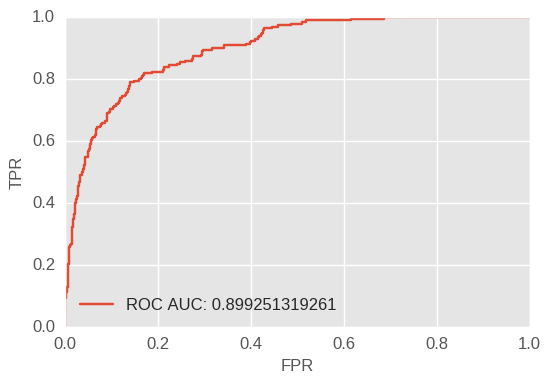

In [166]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

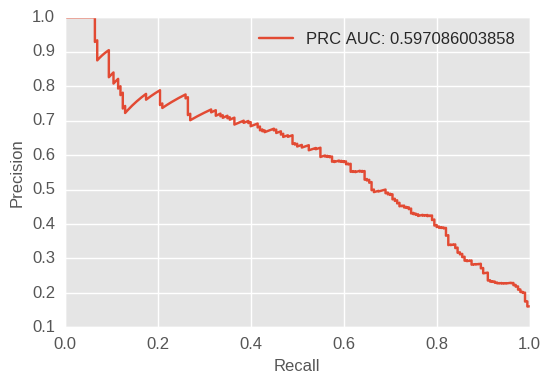

In [167]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

0.910256410256 -0.395370206232


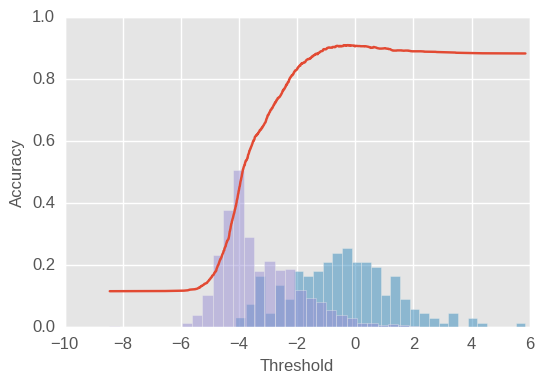

In [168]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [170]:
model_data.day30_mortality.mean()

0.11655011655011654

### Model using continuous MDRD

In [14]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       , 'mech_vent': model_data.mech_vent
       , 'mdrd': model_data.mdrd
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fl_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [174]:
model_code = """

data{
    int<lower=0> N;
    
    int<lower=1, upper=5> ea_lv_systolic[N];
    int<lower=0, upper=1> ex_congestive_heart_failure[N];
    int<lower=0, upper=1> mech_vent[N];
    vector[N] mdrd;
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[5] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    real beta_mech_vent;
    real beta_mdrd;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[5] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    real gamma_mech_vent;
    real gamma_mdrd;
    
    vector[5] gamma_lv_sys_by_chf;
    vector[5] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    for (i in 1:N)
        y_hat[i] <- bias
           + beta_ea_lv_systolic[ea_lv_systolic[i]]
           + beta_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
           + beta_mech_vent*mech_vent[i]
           + beta_mdrd*mdrd[i]
           + beta_apsiii*apsiii[i]
           + beta_age*age[i]
           + fluid_day1_balance[i]*(beta_fluid
              + gamma_ea_lv_systolic[ea_lv_systolic[i]]
              + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure[i]
              + gamma_mech_vent*mech_vent[i]
              + gamma_mdrd*mdrd[i]
              + gamma_lv_sys_by_chf[ea_lv_systolic[i]]*ex_congestive_heart_failure[i]
              + gamma_lv_sys_by_mdrd[ea_lv_systolic[i]] * mdrd[i]
              );
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    beta_mech_vent ~ normal(0,1);
    beta_mdrd ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    gamma_mech_vent ~ normal(0,1);
    gamma_mdrd ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    gamma_lv_sys_by_mdrd ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}

generated quantities{
    

}

"""

In [175]:
model_fit = pystan.stan(model_code=model_code, data=data
                       , iter=2000, chains=1, n_jobs=1, algorithm='NUTS')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ae4395c9ae7a41a9011be8d7cf46195 NOW.


In [176]:
model_fit

Inference for Stan model: anon_model_1ae4395c9ae7a41a9011be8d7cf46195.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bias                               -4.23    0.02   0.55  -5.27   -4.6  -4.23  -3.86  -3.16 1000.0    1.0
beta_ea_lv_systolic[0]              0.49    0.02   0.53  -0.53    0.1    0.5   0.85   1.58 1000.0    1.0
beta_ea_lv_systolic[1]             -0.07    0.02   0.49  -1.05   -0.4  -0.07   0.26   0.94 1000.0    1.0
beta_ea_lv_systolic[2]             -0.61    0.02   0.53  -1.64  -0.98  -0.61  -0.25   0.45 1000.0    1.0
beta_ea_lv_systolic[3]             -0.09    0.02   0.59   -1.3  -0.51  -0.06    0.3   1.02 1000.0    1.0
beta_ea_lv_systolic[4]              0.12    0.02    0.6  -1.03  -0.28   0.11   0.48   1.43 1000.0    1.0
beta_ex_congestive_heart_failure     1.2  9.4e-3    0.3   0.61   1.01    1.2

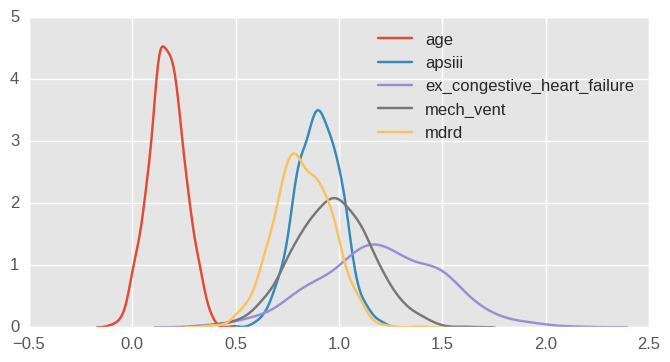

In [179]:
factors = model_fit.extract(['beta_age', 'beta_apsiii', 'beta_ex_congestive_heart_failure', 'beta_mech_vent'
                            , 'beta_mdrd'])
plt.figure(figsize=(8, 4))
for key in ['age', 'apsiii', 'ex_congestive_heart_failure', 'mech_vent', 'mdrd']:
    sns.kdeplot(factors['beta_'+key], label=key)
plt.legend(loc='best')

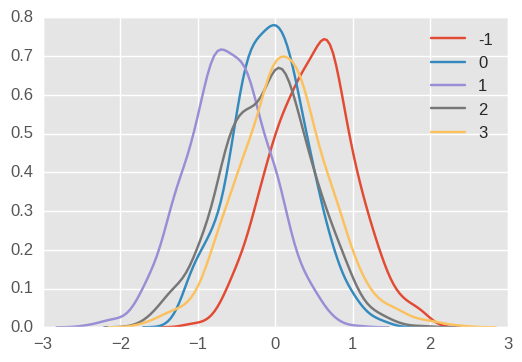

In [182]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

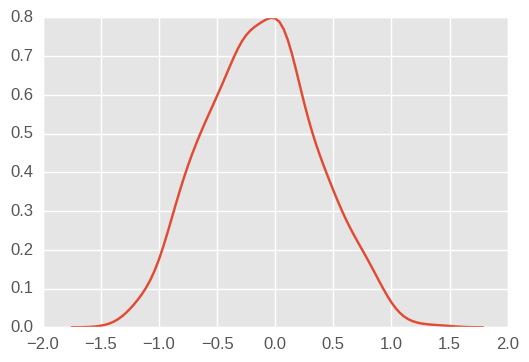

In [180]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

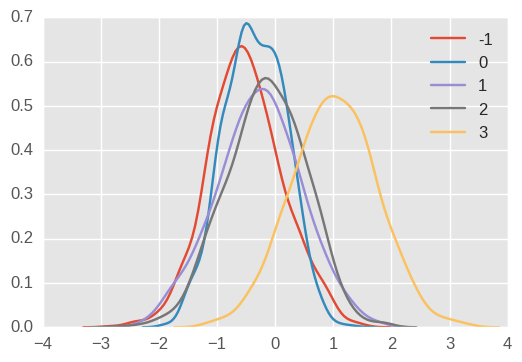

In [181]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

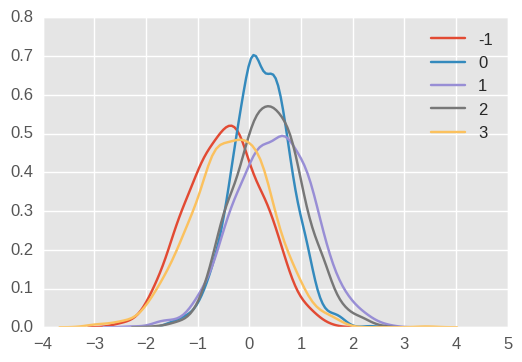

In [194]:
gamma_lv_sys_by_chf = model_fit.extract('gamma_lv_sys_by_chf')['gamma_lv_sys_by_chf']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_chf[:,i], label=str(i-1))
plt.legend(loc='best')

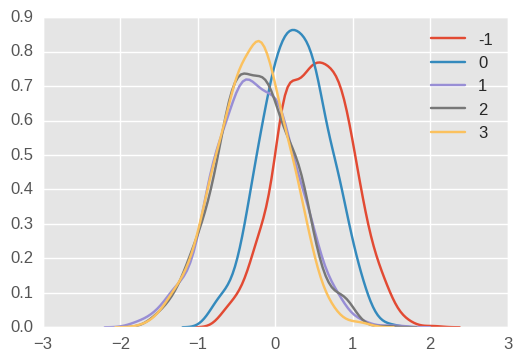

In [195]:
gamma_lv_sys_by_mdrd = model_fit.extract('gamma_lv_sys_by_mdrd')['gamma_lv_sys_by_mdrd']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_mdrd[:,i], label=str(i-1))
plt.legend(loc='best')

In [183]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715
0,-4.880619,-3.566143,-3.100412,-4.906996,1.931139,-2.355343,-4.505114,-2.834772,-3.562339,0.727187,...,-4.196898,-4.091063,-1.718378,-3.922457,-2.795072,-2.649613,-5.207134,-3.523401,-2.134088,-4.278238
1,-4.739766,-3.354327,-2.839304,-4.096396,1.410101,-2.092249,-3.920397,-2.723402,-3.239346,0.144105,...,-3.818416,-3.775345,-1.897201,0.338927,-2.484952,-1.936831,-4.301647,-3.152349,-2.472714,-3.909498
2,-4.749994,-3.370582,-2.694786,-4.269896,1.499813,-2.432477,-4.079625,-2.482004,-3.167444,0.130336,...,-3.930350,-3.902546,-1.680975,-0.509871,-2.919369,-2.857478,-4.519432,-4.201787,-2.290981,-4.098683
3,-4.697461,-3.339072,-2.727772,-4.454079,1.473202,-2.169150,-4.161356,-2.483549,-3.204917,0.139503,...,-3.735666,-3.726043,-2.587982,-1.016892,-2.615692,-2.181438,-4.666687,-3.090779,-2.196160,-3.980061
4,-4.810325,-2.968439,-2.510309,-3.840369,1.877615,-2.040788,-3.569076,-2.455766,-3.047534,0.380586,...,-3.792817,-3.597883,-1.445607,0.624524,-2.383165,-2.292510,-4.164038,-3.280396,-1.813703,-3.577840


In [184]:
y_hat_mu = y_hats.mean()

In [185]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [186]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.91142191142191142

In [187]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

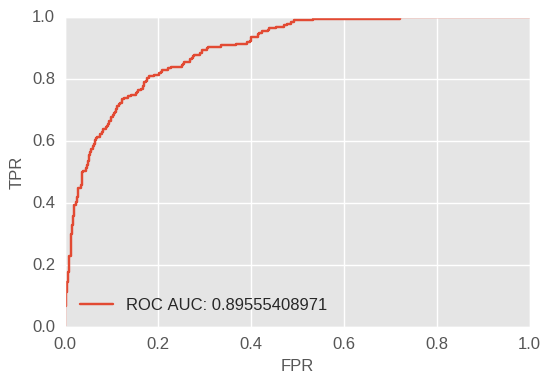

In [188]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

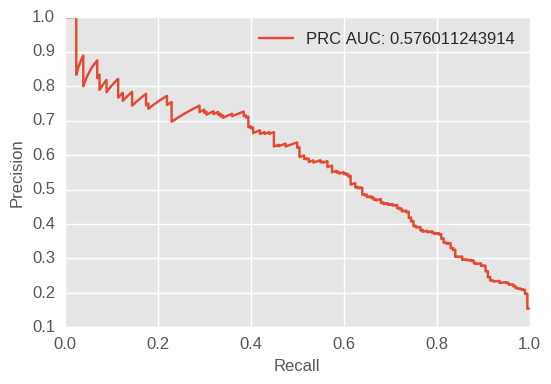

In [189]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

0.910839160839 -0.0219392259983


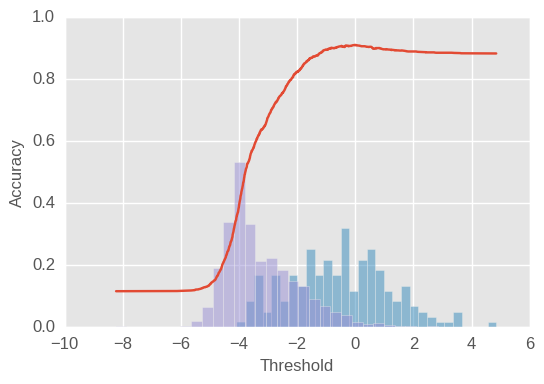

In [190]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [191]:
model_data.day30_mortality.mean()

0.11655011655011654